In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# ДЗ

Провести анализ с помощью SSA любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). 

- Посмотрите на результаты с разными длинами окон. 
- Обязательно визуализируйте результаты, аналогично материалу с занятия.

### Choose and Prepare Data

In [4]:
df = pd.read_csv('Stock_Exchange_Data/indexData.csv')

In [5]:
pd.read_csv('Stock_Exchange_Data/indexInfo.csv').head()

,Region,Exchange,Index,Currency
0,United States,New York Stock Exchange,NYA,USD
1,United States,NASDAQ,IXIC,USD
2,Hong Kong,Hong Kong Stock Exchange,HSI,HKD
3,China,Shanghai Stock Exchange,000001.SS,CNY
4,Japan,Tokyo Stock Exchange,N225,JPY


We will use NASDAQ prices

In [9]:
nasdaq = pd.DataFrame( df[df.Index == 'IXIC'] )

In [ ]:
nasdaq.reset_index(drop=True,inplace=True)

In [20]:
nasdaq.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,Average
0,IXIC,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0.0,100.000000
1,IXIC,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0.0,100.839996
2,IXIC,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0.0,100.760002
3,IXIC,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0.0,100.690002
4,IXIC,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0.0,101.449997


Make average for series:

In [19]:
nasdaq['Average'] = nasdaq.apply( lambda x: (x.High + x.Low)/2 ,axis=1)

In [24]:
series = nasdaq.Average
del nasdaq
series = np.array(series)

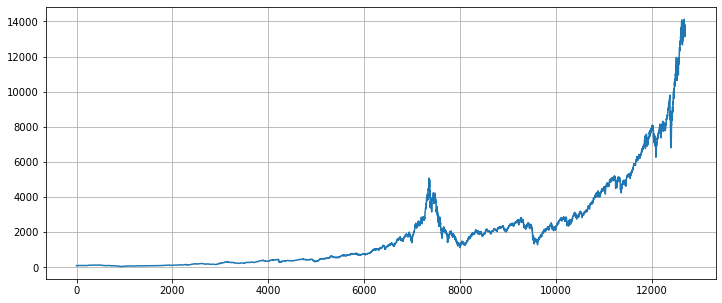

In [29]:
plt.plot(series)
plt.grid()

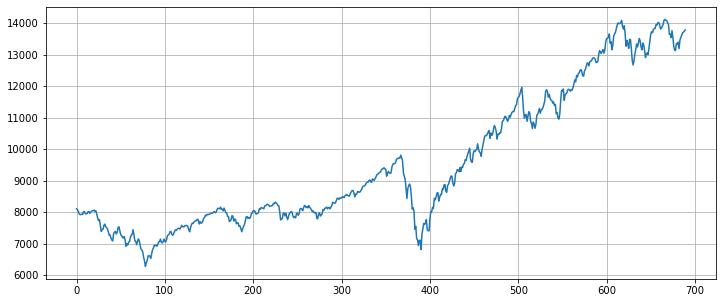

In [42]:
plt.plot(series[12000:])
plt.grid()

In [33]:
old_series, series = series, series[12000:]

In [34]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
    

### TS to SVD and back (PCA?)

Ряд Индекса Nasdaq очень познователен, но модель PCA очень плохо отлавливает компоненты, сравните: 

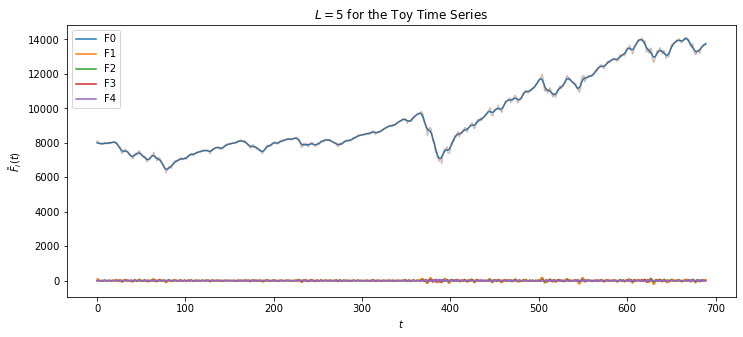

In [59]:
TS_to_SVD_lag_5 = SSA(series,5)
TS_to_SVD_lag_5.components_to_df().plot()
TS_to_SVD_lag_5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Toy Time Series");

И приведенный к стационарном виду ряд:

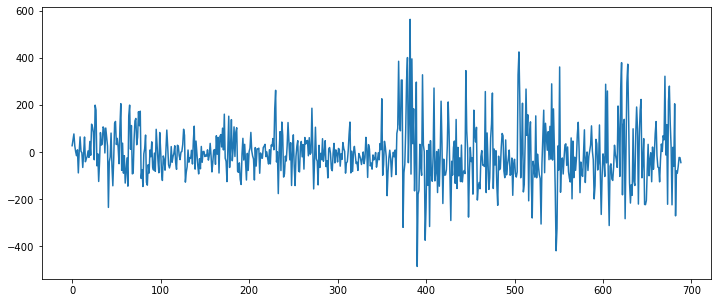

In [51]:
y = series[:-4] - series[4:]
plt.plot(y)

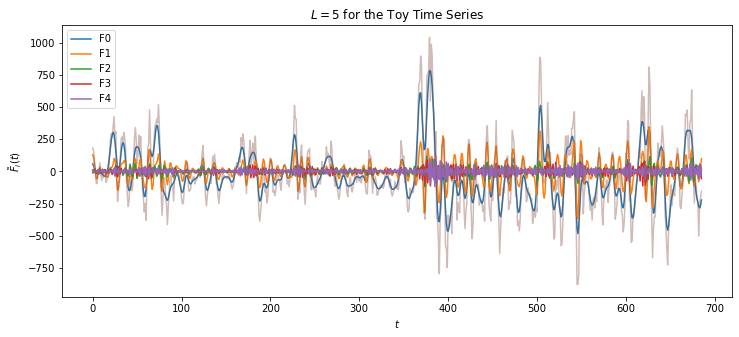

In [58]:
TS_to_SVD_lag_5 = SSA(y,5)
TS_to_SVD_lag_5.components_to_df().plot()
TS_to_SVD_lag_5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Toy Time Series");

Буду использовать индекс Nasdaq приведенный к стационарному виду - дифференциованием (4)

In [60]:
series =  series[:-4] - series[4:]
del y

#### lag=2

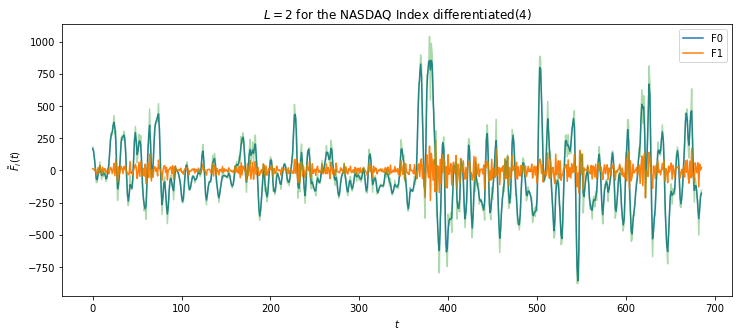

In [67]:
# L=2
TS_to_SVD_lag_2 = SSA(series,2)
TS_to_SVD_lag_2.components_to_df().plot()
TS_to_SVD_lag_2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the NASDAQ Index differentiated(4)");

#### lag=5

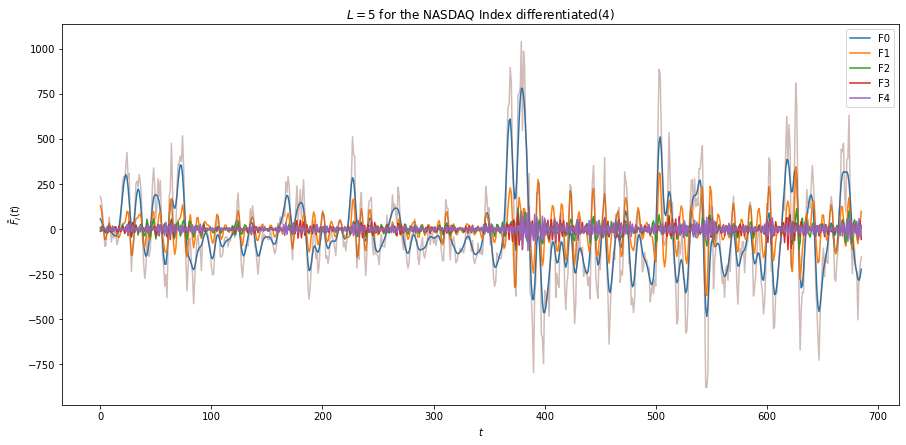

In [73]:
TS_to_SVD_lag_5 = SSA(series,5)
TS_to_SVD_lag_5.components_to_df().plot()
TS_to_SVD_lag_5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the NASDAQ Index differentiated(4)");

Уже стала заметна первая компонента - указывает на тренд.  

Очень похоже что вторая компонента указывает на сигму

#### lag=12

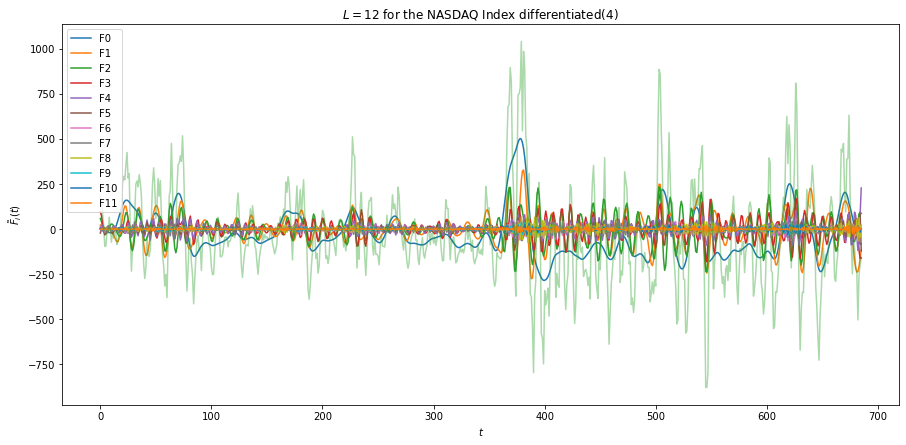

In [72]:
TS_to_SVD_lag_12 = SSA(series,12)

plt.rcParams['figure.figsize'] = (15,7)
TS_to_SVD_lag_12.components_to_df().plot()
TS_to_SVD_lag_12.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=12$ for the NASDAQ Index differentiated(4)");

Уже четко видно, первая компонента - указывает на тренд.  

Вторая компонента - указывает на дисперсию ряда (увеличивается когда амплитуда растет).  

Третья компонента - указывает на сезонность ряда 

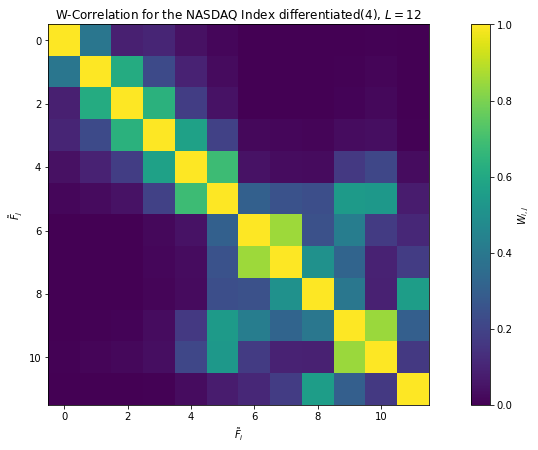

In [74]:
TS_to_SVD_lag_12.plot_wcorr()
plt.title("W-Correlation for the NASDAQ Index differentiated(4), $L=12$");

Первые 5 компонент не имеют корреляции с остальными компонентами - стало быть, информативными являются они.

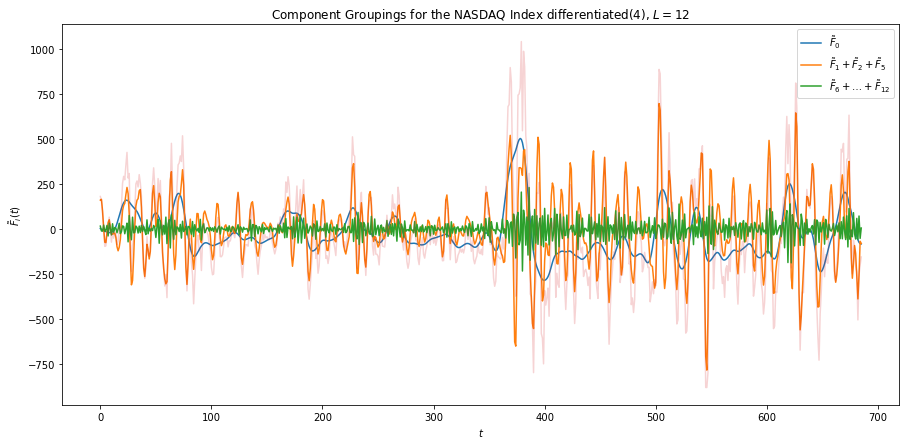

In [83]:
TS_to_SVD_lag_12.reconstruct(0).plot()
TS_to_SVD_lag_12.reconstruct([1,2,3,4,5]).plot()
TS_to_SVD_lag_12.reconstruct(slice(6,12)).plot()
#TS_to_SVD_lag_12.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the NASDAQ Index differentiated(4), $L=12$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_5$", 
            r"$\tilde{F}_6+ \ldots + \tilde{F}_{12}$"]); #,
            #r"$\tilde{F}_3$"
TS_to_SVD_lag_12.orig_TS.plot(alpha=0.2);

Очень хорошо отделились:

    - тренд (0)  
    - сезонность (1-5)
    - остальной шум (6-12)

#### lag=70

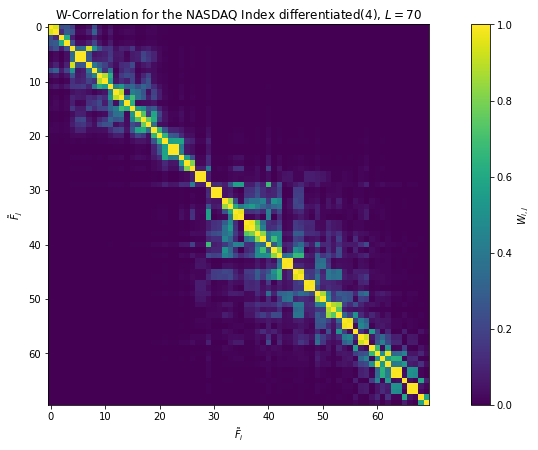

In [86]:
TS_to_SVD_lag_70 = SSA(series,70)

TS_to_SVD_lag_70.plot_wcorr()
plt.title("W-Correlation for the NASDAQ Index differentiated(4), $L=70$");

Заметны 5 кластеров, попробуем собрать и отрисовать их

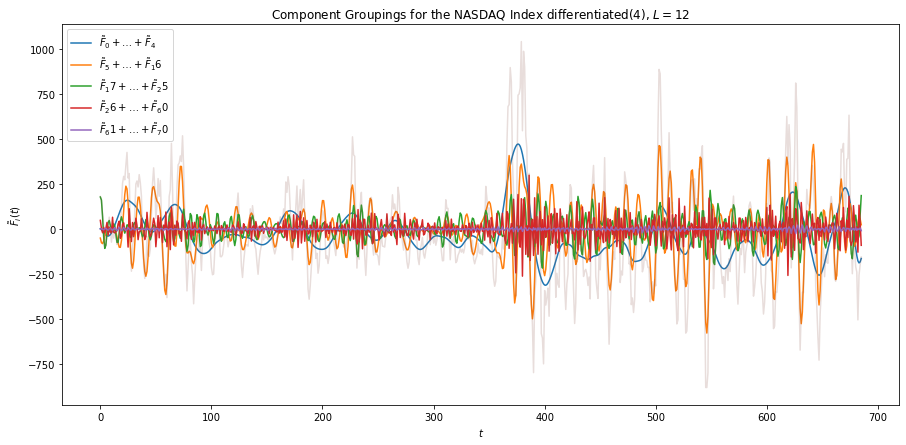

In [91]:
TS_to_SVD_lag_70.reconstruct(slice(0,4)).plot()
TS_to_SVD_lag_70.reconstruct(slice(5,16)).plot()
TS_to_SVD_lag_70.reconstruct(slice(17,25)).plot()
TS_to_SVD_lag_70.reconstruct(slice(26,60)).plot()
TS_to_SVD_lag_70.reconstruct(slice(61,70)).plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the NASDAQ Index differentiated(4), $L=12$");
plt.legend([r"$\tilde{F}_0+ \ldots +\tilde{F}_4$", 
            r"$\tilde{F}_5+ \ldots +\tilde{F}_16$",
            r"$\tilde{F}_17+ \ldots +\tilde{F}_25$",
            r"$\tilde{F}_26+ \ldots +\tilde{F}_60$",
            r"$\tilde{F}_61+ \ldots +\tilde{F}_70$"]);

TS_to_SVD_lag_12.orig_TS.plot(alpha=0.2);

Ничего не поменялось: компонента 1 (тренд) и компоненты 2-6 (сезонность) 

# Попробуем два ML варианта с лагом 12:
 1. обучим на компонентах 1 (тренд) и 2-6 (сезонность) Random Forest 
 1. обучим линейную регрессию на остатках и соберем y =  1 компонента(тренд) + 2-6 компонента(сезонность) + остатки (LiearRegression)
 
Все модели проверим на валидационной выборке по MSE

#### Train test split

In [111]:
#Train test 
test_size = .2
train_length = int( len(series) * (1- test_size) )

y_train, y_test  = series[:train_length] , series[train_length :]
len(y_train), len(y_test)

(548, 138)

In [113]:
# создем компоненты 1 (тренд) и 2-6 (сезонность) на трейне и тесте
#train
train_TS_to_SVD_lag_12 = SSA(y_train,12)

train_trend = train_TS_to_SVD_lag_12.reconstruct(0)
train_seasonal = train_TS_to_SVD_lag_12.reconstruct([1,2,3,4,5])

#test
test_TS_to_SVD_lag_12 = SSA(y_test,12)

test_trend = test_TS_to_SVD_lag_12.reconstruct(0)
test_seasonal = test_TS_to_SVD_lag_12.reconstruct([1,2,3,4,5])

In [109]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Random Forest

In [98]:
# Обучаем Random Forest на трейне компоненты 1 (тренд) и 2-6 (сезонность)
rf = RandomForestRegressor( n_estimators=100, criterion='mse', max_depth=None, n_jobs=-1)

In [108]:
X_train_components = pd.concat((train_trend,train_seasonal),axis=1)

In [107]:
rf.fit(X_train_components,y_train)

RandomForestRegressor(n_jobs=-1)

In [115]:
# Random Forest predict на тесте. MSE
X_test_components = pd.concat((test_trend,test_seasonal),axis=1)
y_pred = rf.predict(X_test_components)
mean_squared_error(y_test, y_pred)

4890.9481257359585

Random Forest MSE = 4890.

### LinearRegression

In [122]:
# собираем остатки из 1 (тренд) + 2-6 (сезонность) на трейне и тесте
y_train_trend_seasonal = train_trend + train_seasonal
resid = y_train - y_train_trend_seasonal

In [123]:
# обучаем LinReg на остатках трейна
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train_components,resid)

LinearRegression(n_jobs=-1)

In [128]:
# делаем предикт на тесте .MSE
y_pred_linreg = linreg.predict(X_test_components)
y_pred = y_pred_linreg + test_trend + test_seasonal
mean_squared_error(y_test, y_pred)

3252.8804025317318

LinearRegression MSE = 3252

# Вывод: 
Было сделано следующее: два ML варианта с лагом 12:

    - обучен на компонентах 1 (тренд) и 2-6 (сезонность) Random Forest
    - обучена линейная регрессию на остатках

Все модели проверены на валидационной выборке по MSE

    - Random Forest прогнозировал на тест компонентах 1 (тренд) и 2-6 (сезонность) 
    - LinearRegression прогнозировал на y_pred = 1 компонента(тренд) + 2-6 компонента(сезонность) + остатки (LiearRegression)

## Результаты:

    - Random Forest MSE = 4890
    - LinearRegression MSE = 3252
    
LinearRegression обучаенная на остаткх от первых 6 компонент показала наилучший результат.